# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset Source:-

https://www.kaggle.com/mirichoi0218/insurance

In [2]:
!wget https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/insurance.csv

--2022-09-07 11:27:02--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54289 (53K) [text/plain]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  53.02K  --.-KB/s    in 0.01s   

2022-09-07 11:27:02 (4.82 MB/s) - ‘insurance.csv’ saved [54289/54289]



In [3]:
df=pd.read_csv('/content/insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let us see at each feature, their type, and number of non-null values contained with .info() function:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


As can be seen above, there are three numerical features and three categorical features, also it looks like our dataset does not contain any null value, because of this we will not have to do imputation process.

In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Exploration of features and label:

In order to see at the distribution and behaviour of our features, let us see the histogram of our numerical features and the label:

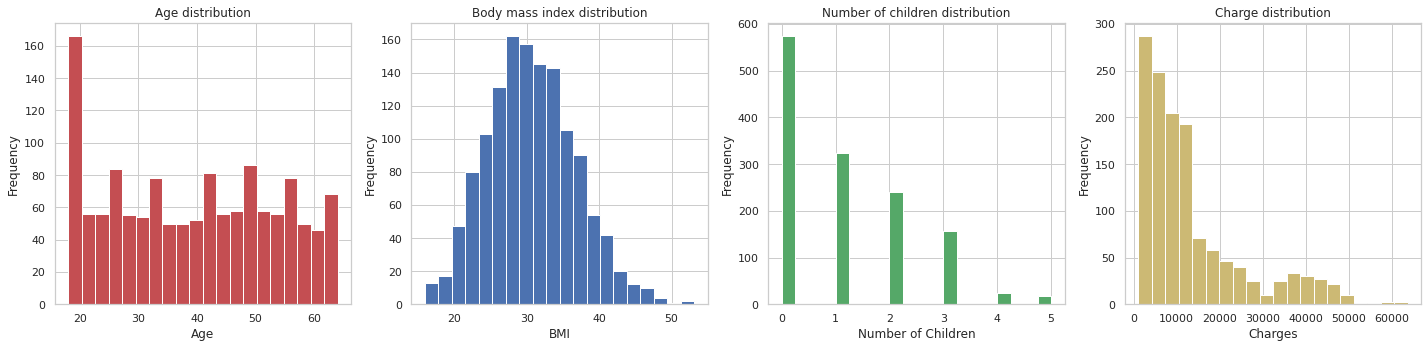

In [8]:
sns.set(style='whitegrid')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

df['age'].hist(bins=20, color='r', ax=ax1)
ax1.set_title('Age distribution')
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequency")

df['bmi'].hist(bins=20, color='b', ax=ax2)
ax2.set_title('Body mass index distribution')
ax2.set_xlabel("BMI")
ax2.set_ylabel("Frequency")

df['children'].hist(bins=20, color='g', ax=ax3)
ax3.set_title('Number of children distribution')
ax3.set_xlabel("Number of Children")
ax3.set_ylabel("Frequency")

df['charges'].hist(bins=20, color='y', ax=ax4)
ax4.set_title('Charge distribution')
ax4.set_xlabel("Charges")
ax4.set_ylabel("Frequency")

f.tight_layout()

From the charts above we could say distribution of Age tends to be uniform with a huge frequency in 20 years; about Body Mass Index is gaussian shaped which is considerably good taking into account that linear models are based on normal features; Children is discrete and easily could be used as categorical, but it makes sense as numerical, whereas the label has a strongly right skewed, thus we have to transform it using any method such as log1p or coxbox.

Let us see now at the proportion of classes if our categorical features as pie charts: 

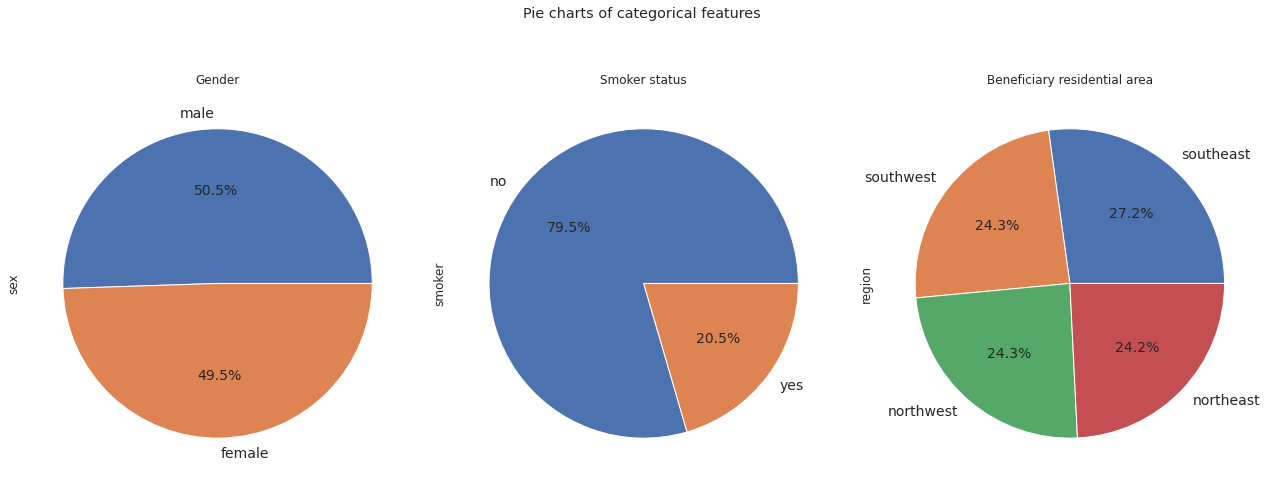

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,8))

pie1=pd.DataFrame(df['sex'].value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Gender',y = 'sex', 
             autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, ax=ax1)

pie2=pd.DataFrame(df['smoker'].value_counts())
pie2.reset_index(inplace=True)
pie2.plot(kind='pie', title='Smoker status',y = 'smoker', 
             autopct='%1.1f%%', shadow=False, labels=pie2['index'], legend = False, fontsize=14, ax=ax2)

pie3=pd.DataFrame(df['region'].value_counts())
pie3.reset_index(inplace=True)
pie3.plot(kind='pie', title='Beneficiary residential area',y = 'region', 
             autopct='%1.1f%%', shadow=False, labels=pie3['index'], legend = False, fontsize=14, ax=ax3)

f.suptitle('Pie charts of categorical features')
f.tight_layout()

Two of our categorical variables are binary and the third has 4 classes, which we have to encode next in feature engineering.

Gender and Region features are balanced and smoker is the unique features unbalanced with a proportion of 4:1, later we will see if this affects our prediction.

Something interesting to show is the distribution of the label or relation with each feature, as can be seen below we will plot the charges by each of the classes in the categorical features: 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Charge distribution by gender')

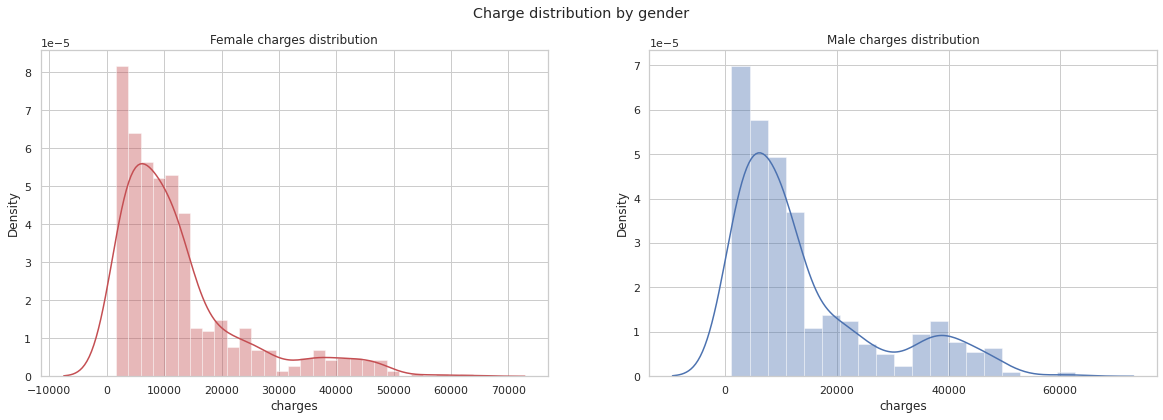

In [10]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
sns.distplot(df[df['sex']=='female']['charges'],kde=True,color='r', ax=ax1)
ax1.set_title('Female charges distribution')
sns.distplot(df[df['sex']=='male']['charges'],kde=True,color='b', ax=ax2)
ax2.set_title('Male charges distribution')

f.suptitle('Charge distribution by gender')

In the figure above, both curves drawn in the charts look similar with a slightly higher amount for male.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Charge distribution for smoker status')

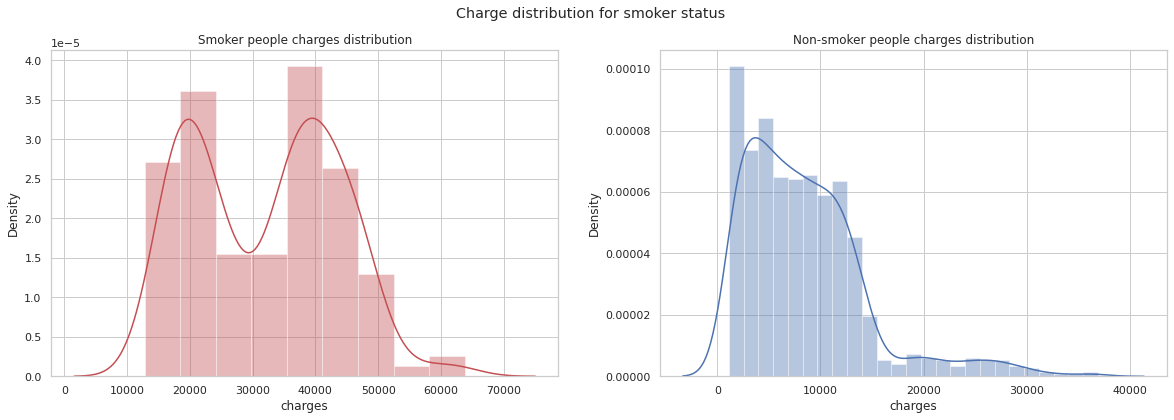

In [11]:
sns.set(style='whitegrid')
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
sns.distplot(df[df['smoker']=='yes']['charges'],kde=True,color='r', ax=ax1)
ax1.set_title('Smoker people charges distribution')
sns.distplot(df[df['smoker']=='no']['charges'],kde=True,color='b', ax=ax2)
ax2.set_title('Non-smoker people charges distribution')

f.suptitle('Charge distribution for smoker status')

In the figure above, makes sense that for smoker people the cost of the insurance should be higher as their risk of suffering a long-term disease is much higher than non-smoker, also the frequency of people whose charge is significantly higher in smoker people.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0.98, 'Charge distribution by region')

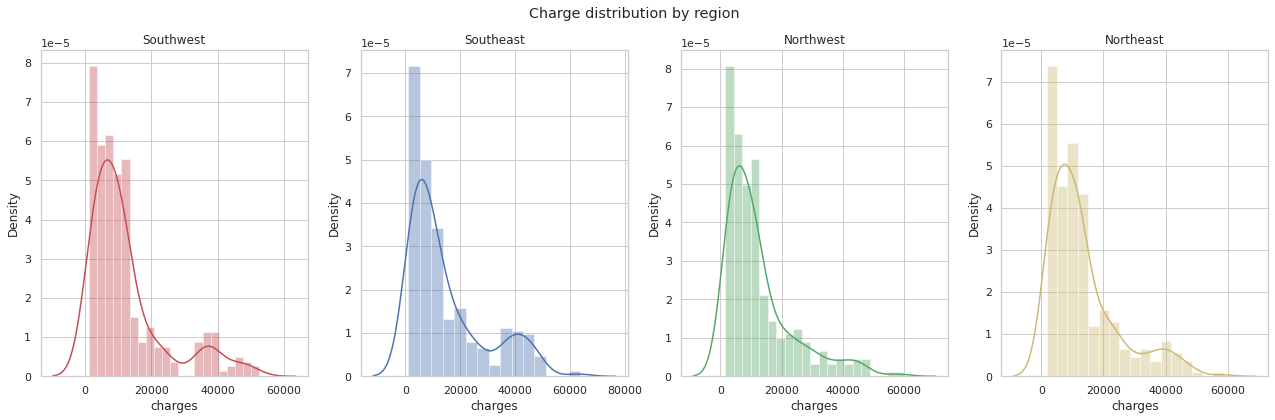

In [12]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(22,6))
sns.distplot(df[df['region']=='southwest']['charges'],kde=True,color='r', ax=ax1)
ax1.set_title('Southwest')
sns.distplot(df[df['region']=='southeast']['charges'],kde=True,color='b', ax=ax2)
ax2.set_title('Southeast')
sns.distplot(df[df['region']=='northwest']['charges'],kde=True,color='g', ax=ax3)
ax3.set_title('Northwest')
sns.distplot(df[df['region']=='northeast']['charges'],kde=True,color='y', ax=ax4)
ax4.set_title('Northeast')

f.suptitle('Charge distribution by region')

Overall the four plots are quite similar, between them  southeast have the lowest charges and at the same time has less frequency than others.

Now, let us plot the regression plots and see if there is a notable correlation of label with features:

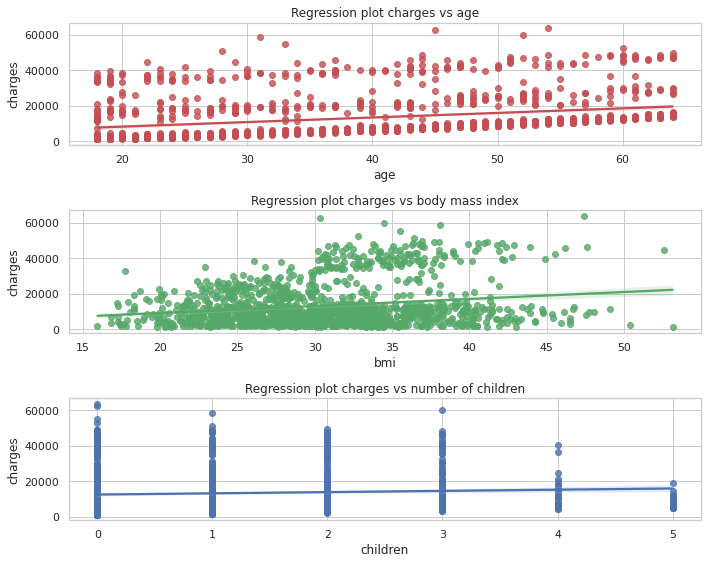

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8))
sns.regplot(x='age', y='charges', data=df, color='r', ax=ax1)
ax1.set_title('Regression plot charges vs age')

sns.regplot(x='bmi', y='charges', data=df, color='g', ax=ax2)
ax2.set_title('Regression plot charges vs body mass index')

sns.regplot(x='children', y='charges', data=df, color='b', ax=ax3)
ax3.set_title('Regression plot charges vs number of children')

#f.suptitle('Regression plots of Charge with numerical features')
f.tight_layout()

Above, the unique feature with a slightly notable correlation is age, although it's not big next we will see its impact in the prediction of charge with our model.

# Feature Engineering:

Encoding: 

We have 2 types of categorical features binary and nominal, as we know those binary can take values either 1 or 0, whereas nominal ones must be one-hot encoded using get_dummies.

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Binarizing of gender and smoker features:

In [15]:
df['sex']=df['sex'].replace('male',1).replace('female',0)

In [16]:
df['smoker']=df['smoker'].replace('yes',1).replace('no',0)

One-hot encoding of region feature:

In [17]:
df = pd.get_dummies(df, columns=['region'], drop_first=True) #To avoid multicollinearity

Above I specified drop_first=True in order to omit one of the classes, because that one is equivalent when all classes are 0, this method applied to datasets with hundreds of categorical features helps to reduce the curse of dimentionality. 

In [18]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


The next step after our categorical features are properly encoded is to create polynomial features from the numericals so as to increase the significance of information given to the model. 

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
df_num=df[['age','bmi','children']]   #Numerical columns

In [21]:
pf = PolynomialFeatures(degree=2, include_bias=False)
df_pf = pf.fit_transform(df_num)

The polynomial function of these 3 features creates 9 values per instance omiting the bias, therefore at the end of the processing our dataset should have 14 features and the label.

In [22]:
df_pf.shape

(1338, 9)

The following line of code helps to keep the name of the features in the new ones:

In [23]:
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_num.columns,p) for p in pf.powers_]]
output_df = pd.DataFrame(df_pf, columns = target_feature_names, index=df.index)

In [24]:
output_df.head()

,age^1,bmi^1,children^1,age^2,age^1xbmi^1,age^1xchildren^1,bmi^2,bmi^1xchildren^1,children^2
0,19.0,27.900,0.0,361.0,530.100,0.0,778.410000,0.00,0.0
1,18.0,33.770,1.0,324.0,607.860,18.0,1140.412900,33.77,1.0
2,28.0,33.000,3.0,784.0,924.000,84.0,1089.000000,99.00,9.0
3,33.0,22.705,0.0,1089.0,749.265,0.0,515.517025,0.00,0.0
4,32.0,28.880,0.0,1024.0,924.160,0.0,834.054400,0.00,0.0


In [25]:
df.drop(['age','bmi','children'], axis=1, inplace=True)

In [26]:
df = pd.concat((df, output_df), axis=1)

In [27]:
df

,sex,smoker,charges,region_northwest,region_southeast,region_southwest,age^1,bmi^1,children^1,age^2,age^1xbmi^1,age^1xchildren^1,bmi^2,bmi^1xchildren^1,children^2
0,0,1,16884.92400,0,0,1,19.0,27.900,0.0,361.0,530.100,0.0,778.410000,0.00,0.0
1,1,0,1725.55230,0,1,0,18.0,33.770,1.0,324.0,607.860,18.0,1140.412900,33.77,1.0
2,1,0,4449.46200,0,1,0,28.0,33.000,3.0,784.0,924.000,84.0,1089.000000,99.00,9.0
3,1,0,21984.47061,1,0,0,33.0,22.705,0.0,1089.0,749.265,0.0,515.517025,0.00,0.0
4,1,0,3866.85520,1,0,0,32.0,28.880,0.0,1024.0,924.160,0.0,834.054400,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,1,0,10600.54830,1,0,0,50.0,30.970,3.0,2500.0,1548.500,150.0,959.140900,92.91,9.0
1334,0,0,2205.98080,0,0,0,18.0,31.920,0.0,324.0,574.560,0.0,1018.886400,0.00,0.0
1335,0,0,1629.83350,0,1,0,18.0,36.850,0.0,324.0,663.300,0.0,1357.922500,0.00,0.0
1336,0,0,2007.94500,0,0,1,21.0,25.800,0.0,441.0,541.800,0.0,665.640000,0.00,0.0


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,1338.0,0.505232,0.500160,0.0000,0.000000,1.000,1.000000,1.00000
smoker,1338.0,0.204783,0.403694,0.0000,0.000000,0.000,0.000000,1.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.287150,9382.033,16639.912515,63770.42801
region_northwest,1338.0,0.242900,0.428995,0.0000,0.000000,0.000,0.000000,1.00000
region_southeast,1338.0,0.272048,0.445181,0.0000,0.000000,0.000,1.000000,1.00000
region_southwest,1338.0,0.242900,0.428995,0.0000,0.000000,0.000,0.000000,1.00000
age^1,1338.0,39.207025,14.049960,18.0000,27.000000,39.000,51.000000,64.00000
bmi^1,1338.0,30.663397,6.098187,15.9600,26.296250,30.400,34.693750,53.13000
children^1,1338.0,1.094918,1.205493,0.0000,0.000000,1.000,2.000000,5.00000
age^2,1338.0,1734.444694,1125.768602,324.0000,729.000000,1521.000,2601.000000,4096.00000


The last step of feature engineering is the normalization of the label, which will be done by applying the logarithmic function:

Text(0, 0.5, 'Frequency')

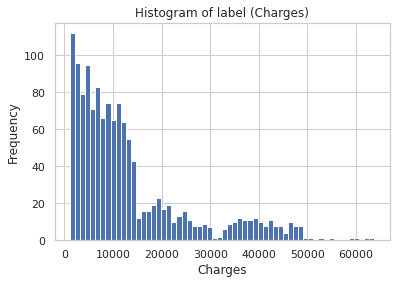

In [29]:
df.charges.hist(bins=60)
plt.title('Histogram of label (Charges)')
plt.xlabel('Charges')
plt.ylabel('Frequency')

In [30]:
df['charges'].skew()

1.5158796580240388

We will use the statistical test D'Agostino, which needs to declare a null hypothesis and alternative hypothesis. This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal. Defining a threshold of 0.05 means that if such value is lower we reject the null hypothesis that the distribution is normal and viceversa.

- H0: The distribution is Normal.
- H1: The distribution is not Normal.

In [31]:
from scipy.stats.mstats import normaltest

In [32]:
normaltest(df['charges'].values)

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

As p-value is much lower than 0.05 we reject H0, therefore we will apply the log function to convert our label.

In [33]:
label=np.log(df['charges'])

Text(0, 0.5, 'Frequency')

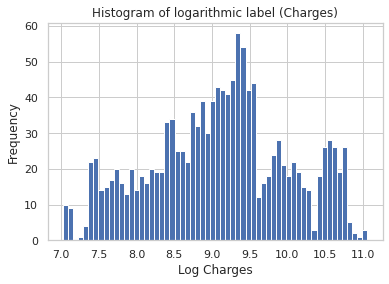

In [34]:
plt.hist(label, bins=60)
plt.title('Histogram of logarithmic label (Charges)')
plt.xlabel('Log Charges')
plt.ylabel('Frequency')

In [35]:
pd.DataFrame(label).skew()

charges   -0.090098
dtype: float64

The skew of the label is much lower and we have to remember once we have the prediction to move back apply anti-log in order to get back to the original 'dimention'.

In [36]:
len(label)

1338

In [37]:
df.drop(['charges'], axis=1, inplace=True)

In [38]:
df

,sex,smoker,region_northwest,region_southeast,region_southwest,age^1,bmi^1,children^1,age^2,age^1xbmi^1,age^1xchildren^1,bmi^2,bmi^1xchildren^1,children^2
0,0,1,0,0,1,19.0,27.900,0.0,361.0,530.100,0.0,778.410000,0.00,0.0
1,1,0,0,1,0,18.0,33.770,1.0,324.0,607.860,18.0,1140.412900,33.77,1.0
2,1,0,0,1,0,28.0,33.000,3.0,784.0,924.000,84.0,1089.000000,99.00,9.0
3,1,0,1,0,0,33.0,22.705,0.0,1089.0,749.265,0.0,515.517025,0.00,0.0
4,1,0,1,0,0,32.0,28.880,0.0,1024.0,924.160,0.0,834.054400,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,1,0,1,0,0,50.0,30.970,3.0,2500.0,1548.500,150.0,959.140900,92.91,9.0
1334,0,0,0,0,0,18.0,31.920,0.0,324.0,574.560,0.0,1018.886400,0.00,0.0
1335,0,0,0,1,0,18.0,36.850,0.0,324.0,663.300,0.0,1357.922500,0.00,0.0
1336,0,0,0,0,1,21.0,25.800,0.0,441.0,541.800,0.0,665.640000,0.00,0.0


# Modeling:

The following models will be built and compared using their corresponding error measurements:

- Linear Regression.
- Ridge Regression with Cross-validation.
- Lasso Regression with Cross-validation.


Before building the different models let's declare some error metrics in order to compare the performace of each one:

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def error_metrics(y_pred,y_val):
  print('MSE: ',mean_squared_error(y_pred,y_val))
  print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_val)))
  print('Coefficient of determination: ',r2_score(y_pred,y_val))

Mean squared error computes the squared of the differences between the predicted and actual values per instance, then adds them up and finally takes the average.
$$
MSE=\frac{1}{N}\sum_{j=1}^{n} (y_j - \hat{y_j})^2\\ 
$$
Root mean squared error consist of computing the square root of the MSE.

$$
RMSE=\sqrt[2]{\sum_{j=1}^{n}\frac{(y_j - \hat{y_j})^2}{N}} \\ 
$$

Coefficient of determination takes into account the square of the differences and the square of the difference of actual values with mean of values. As can be seen in the formula below, as the numerator decreases the metric will tend to 1.0 which means the proportion of the variance in the dependent variable (label) that is predictable from the independent variables. 

$$
R^2=\ 1 - \frac{\sum_{j=1}^{n} (y_j - \hat{y_j})^2}{\sum_{j=1}^{n} (y_j - \mu)^2}
$$

Ideally this metric should be very close to 1.0 to have a powerful model.


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_val, label_train, label_val = train_test_split(df, label, test_size=0.15, random_state=42)

In [42]:
X_train.shape, label_train.shape, X_val.shape, label_val.shape

((1137, 14), (1137,), (201, 14), (201,))

The next step is to standardize our features so that they can have a mean of 0.0 and unitary standard deviation:

In [43]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

X_train_scaled = s.fit_transform(X_train)
X_val_scaled = s.transform(X_val)

1. **Linear regression**:

In [44]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression().fit(X_train_scaled, label_train)

y_pred = linearRegression.predict(X_val_scaled)

error_metrics(y_pred,label_val)

MSE:  0.1725732138508936
RMSE:  0.4154193229146829
Coefficient of determination:  0.7672600627397954


In [45]:
linearRegression.score(X_val_scaled, label_val)

0.8073560218213742

The following two models are modifications of typical linear regression in which a penalty is applied for each coefficient in order to reduce its impactfulness leading to reduce overfitting and add generalization, such function is changed by adjusting the alpha value.

2. **Ridge Regression** with Cross-validation: L2 regularization technique well-known for applying a penalty proportional to the squared magnitude of the coefficients. 

In [46]:
from sklearn.linear_model import RidgeCV

alphas = [0.007, 0.009, 0.002, 0.01]

ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train_scaled, label_train)

ridgeCV_pre = ridgeCV.predict(X_val_scaled)

print('Alpha found: ',ridgeCV.alpha_)
error_metrics(ridgeCV_pre,label_val)

Alpha found:  0.01
MSE:  0.17256828552086395
RMSE:  0.41541339111885156
Coefficient of determination:  0.7672565992373197


In [47]:
ridgeCV.score(X_val_scaled, label_val)

0.8073615233304526

3. **Lasso Regression** with Cross-validation: L1 regularization technique in which a penalty proportional to the absolute value of the coefficients is applied. One characteristic particular of lasso is that it lead to reduce the magnitude of some coefficients to zero helping also to feature selection.

In [48]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-6, 5e-6, 1e-5, 2e-5, 1e-3])

lassoCV = LassoCV(alphas=alphas2, max_iter=5e4, cv=3).fit(X_train_scaled, label_train)

lassoCV_pre = lassoCV.predict(X_val_scaled)

print('Alpha found: ',lassoCV.alpha_)
error_metrics(lassoCV_pre,label_val)

Alpha found:  2e-05
MSE:  0.17253931207747158
RMSE:  0.4153785166296779
Coefficient of determination:  0.7672545446512833


In [49]:
lassoCV.score(X_val_scaled, label_val)


0.8073938664691824

In [50]:
data = {'Linear': [mean_squared_error(y_pred,label_val),np.sqrt(mean_squared_error(y_pred,label_val)),r2_score(y_pred,label_val)],
        'RidgeCV': [mean_squared_error(ridgeCV_pre,label_val),np.sqrt(mean_squared_error(ridgeCV_pre,label_val)),r2_score(ridgeCV_pre,label_val)],
        'LassoCV': [mean_squared_error(lassoCV_pre,label_val),np.sqrt(mean_squared_error(lassoCV_pre,label_val)),r2_score(lassoCV_pre,label_val)]}
 
pd.DataFrame(data, index=['MSE','RMSE','R2 score'])

,Linear,RidgeCV,LassoCV
MSE,0.172573,0.172568,0.172539
RMSE,0.415419,0.415413,0.415379
R2 score,0.767260,0.767257,0.767255


In the summary above we can see that the three models had almost the same performance and really there is not a big difference, as always it depends on the dataset, there are some in which lasso or ridge outperforms linear significantly, because of this I could think a different approach such as XGBoost or Random Forest Regressors could be suit for this data, but this is something for a next project. Following with our data and models built Simple Linear Regression minimally outperformed the other models so let us analyze a bit more its prediction:

In [51]:
df1=pd.DataFrame(label_val).reset_index()

In [52]:
df2=pd.DataFrame(y_pred, columns=['prediction'])

In [53]:
dfd = pd.concat((df1, df2), axis=1)

Ideally the correlation between the prediction and the actual value of the label should be 1.0 or close. In the following lines we are going to compute such correlation and show the regression plot which as we imagine should have all points along the diagonal line: 

In [54]:
dfd['charges'].corr(dfd['prediction'])

0.9015653322622335

Text(0.5, 1.0, 'Regression plot of predicted charge vs actual charge \n (Logarithmic scale)')

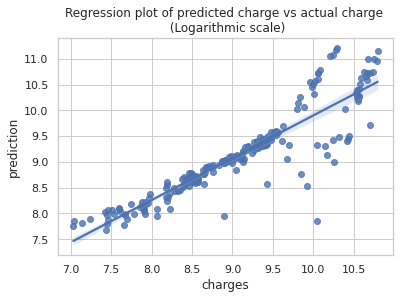

In [55]:
sns.regplot(y='prediction', x='charges', data=dfd)
plt.title('Regression plot of predicted charge vs actual charge \n (Logarithmic scale)')

We can see there are a vast amount of points away of the line, these could be the outliers and one proper method to improve the score can be applying robust scaling or adding more examples to the dataset. Now let us get our prediction back to currency by applying exp():

In [56]:
df11=pd.DataFrame(np.exp(label_val).values, columns=['actual charge'])

In [57]:
df22=pd.DataFrame(np.exp(y_pred), columns=['predicted charge'])

In [58]:
df_concat = pd.concat((df11, df22), axis=1)
df_concat

,actual charge,predicted charge
0,9095.06825,9297.822304
1,5272.17580,5779.785327
2,29330.98315,70856.343811
3,9301.89355,8528.825778
4,33750.29180,12706.387000
...,...,...
196,2709.11190,3125.186226
197,12096.65120,12573.249236
198,2198.18985,2675.367438
199,8932.08400,8616.203798


In the plot below we can see how by applying exponential the outliers get far away, this is definitely not good and a better approach must be taken:

Text(0.5, 1.0, 'Regression plot of predicted charge vs actual charge \n (Currency scale)')

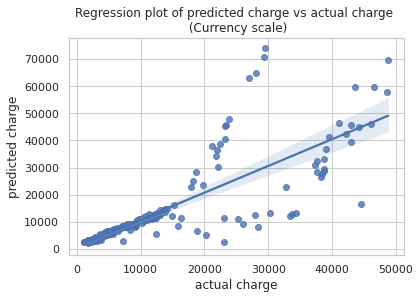

In [59]:
sns.regplot(y='predicted charge', x='actual charge', data=df_concat)
plt.title('Regression plot of predicted charge vs actual charge \n (Currency scale)')